In [83]:
import cv2 as cv
import pyrealsense2 as pr
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

def load_depth_csv(path):
    return pd.read_csv(str(path)).values

def stylize_axes(ax, title="", xlabel="", ylabel="", xticks=[], yticks=[], xticklabels=[], yticklabels=[]):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)


In [21]:
# # import images from csv
lightson_imgs = [load_depth_csv(path) for path in list(Path('./proc_data/inside_lightson/').glob('*.csv'))]
lightsoff_imgs = [load_depth_csv(path) for path in list(Path('./proc_data/inside_lightsoff/').glob('*.csv'))]
outside_imgs = [load_depth_csv(path) for path in list(Path('./proc_data/outside/').glob('*.csv'))]

IMG_SHAPE = lightsoff_imgs[0].shape

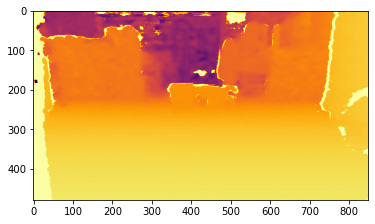

In [7]:
# show an image to check that it worked
plt.imshow(lightson_imgs[3], cmap="inferno_r")


In [135]:
def get_roi_coords_from_patch():
    pass


def get_mean_depth(
    arr,
    origin: tuple[int, int],
    box_size: int,
) -> float:
    """Return mean value for arr in the given region of interest.
    
    Expects (Y, X)
    """
    roi_y, roi_x = origin
    roi = arr[roi_y : roi_y + box_size, roi_x : roi_x + box_size]
    
    mask = np.where(roi > 0, True, False)
    
    
    return np.mean(
        a=roi,
        where=mask)


def extract_depth(
    img_list: list, coord_list: list, figsize: tuple
):
    """ extracts depth data for objects 
    img_list: list of numpy arrays containing depth information
    coord_list: list of tuples containing offset from center X, Y to upper left corner of object box
    figsize: export figure size
    panel_size: height and width for object bounding box
    """
    
    box_depth = []
    plant_depth = []
    print(len(img_list))
    # Create figure
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=figsize, facecolor="white")
    
    # Show the image data in subplots
    ax = ax.flatten()

    for i, a in enumerate(ax):
        x_offset, y_offset, box_size = coord_list[i]
        stylize_axes(a)
        img = img_list[i]

        box_boundary = patches.Rectangle(
            xy=(IMG_SHAPE[1] / 2 + x_offset, IMG_SHAPE[0] + y_offset),
            width=box_size,
            height=box_size,
            edgecolor="r",
            lw=3,
            facecolor="r",
            alpha=0.25,
        )
        a.add_patch(box_boundary)


        plant_boundary = patches.Rectangle(
            xy=(IMG_SHAPE[1] / 2 - int(x_offset / 10), IMG_SHAPE[0] + y_offset),
            width=box_size,
            height=box_size,
            edgecolor="r",
            lw=3,
            facecolor="r",
            alpha=0.25,
        )
        a.add_patch(plant_boundary)

        box_depth.append(get_mean_depth(arr=img, origin=(int(IMG_SHAPE[0] + y_offset), int(IMG_SHAPE[1] / 2 + x_offset)), box_size=box_size))
        plant_depth.append(get_mean_depth(arr=img, origin=(int(IMG_SHAPE[0] + y_offset), int(IMG_SHAPE[1] / 2 - int(x_offset / 10))), box_size=box_size))
        
        a.imshow(img, interpolation="none", cmap="gray")
    
    plt.tight_layout()

    plt.show()

    return box_depth, plant_depth


5


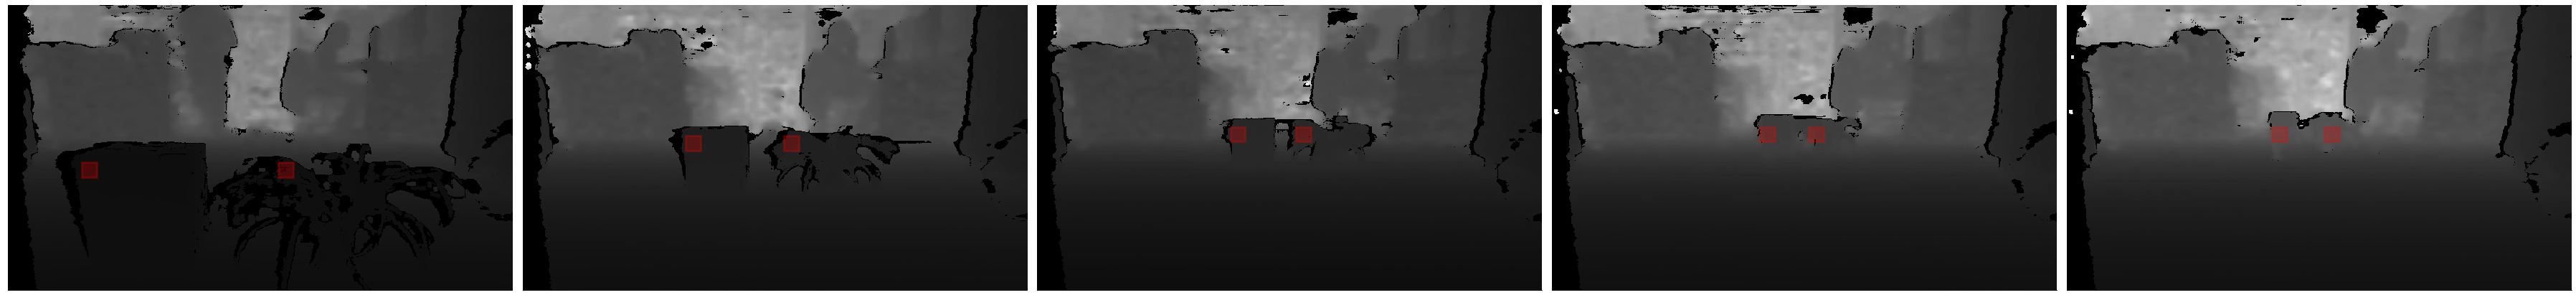

In [138]:

coord_list = [
    (-300, -215, 25),
    (-150, -260, 25),
    (-100, -275, 25),
    (-75, -275, 25),
    (-80, -275, 25),
    
]

on_box_depth, on_plant_depth = extract_depth(lightson_imgs, coord_list, figsize=(50, 10))


5


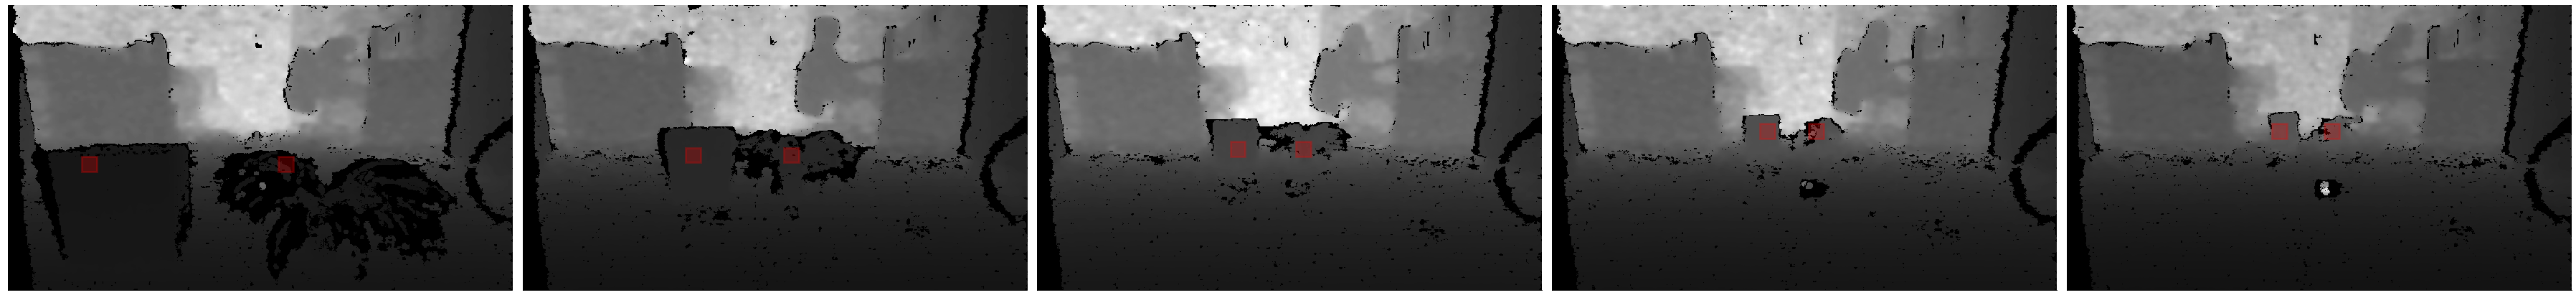

In [141]:


coord_list = [
    (-300, -225, 25),
    (-150, -240, 25),
    (-100, -250, 25),
    (-75, -280, 25),
    (-80, -280, 25),
    
]

off_box_depth, off_plant_depth = extract_depth(lightsoff_imgs, coord_list, figsize=(50, 10))


5


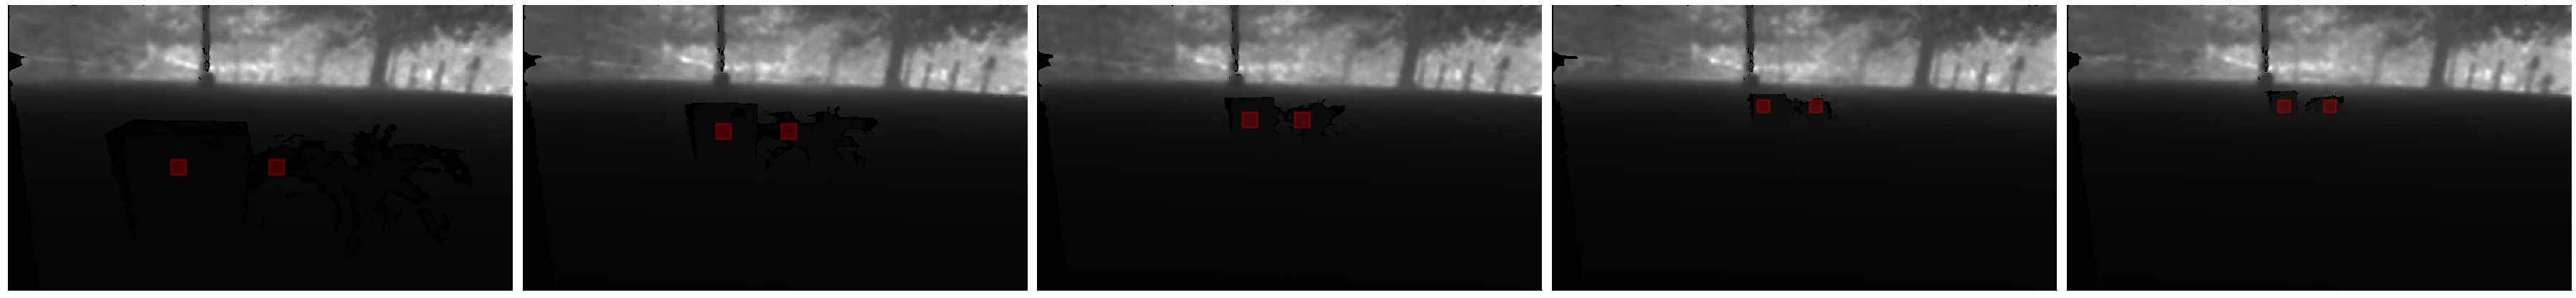

In [148]:


coord_list = [
    (-150, -220, 25),
    (-100, -280, 25),
    (-80, -300, 25),
    (-80, -320, 20),
    (-70, -320, 20),
    
]

out_box_depth, out_plant_depth = extract_depth(outside_imgs, coord_list, figsize=(50, 10))


In [149]:
# create dataframe 

distance = [0.5, 1.0, 1.5, 2.0, 2.5]

depth_df = pd.DataFrame({"true_dist": distance, "box_lights": on_box_depth, "plant_lights": on_plant_depth, "box_dark": off_box_depth, "plant_dark": off_plant_depth, "box_outside": out_box_depth, "plant_outside": out_plant_depth})

dev_df = depth_df.melt(id_vars=["true_dist"], var_name="treatment", value_name="dist")

new = dev_df["treatment"].str.split("_", n = 1, expand = True)

dev_df["object"]= new[0]

dev_df["condition"]= new[1]

dev_df.drop(columns =["treatment"], inplace = True)
  
# dev_df["deviation"] = dev_df["true_dist"] - dev_df["dist"]

print(dev_df.head())



   true_dist      dist object condition
0        0.5  0.541019    box    lights
1        1.0  1.006190    box    lights
2        1.5  1.487580    box    lights
3        2.0  1.956262    box    lights
4        2.5  2.413013    box    lights


In [150]:
#### Ridge regression model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge

# pandas to a numpy array
data = dev_df.values

# reshape, add a dimension so it works in the model
X, y = data[:, 0].reshape(-1, 1), data[:,1].reshape(-1, 1)

# define Ridge regression linear model
lm = Ridge(alpha=1.0)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#evaluate model
scores = np.absolute(cross_val_score(lm, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=1))
print(f"Mean MAE: {np.mean(scores)} ({np.std(scores)})")

# fit model
lm.fit(X, y)

# predictions
y_pred = lm.predict(X)
print(f"coeff: {lm.coef_}, intercept: {lm.intercept_}")


Mean MAE: 0.055561500049011454 (0.02358412089660148)
coeff: [[0.86660076]], intercept: [0.1905762]


In [151]:

# add to dataframe
best_fit = pd.DataFrame({"true_dist":X.flatten(), "best_fit": y_pred.flatten()})

# join column from best_fit into df

dev_df["best_fit"] = best_fit.best_fit
print(f"df_base + base_fit = {dev_df.shape}\n{dev_df.head()}")

# create deviation
# calculate deviation by subtracting the line value from the reading values for ALL data
dev_df["deviation"] = dev_df.dist - dev_df.true_dist
#dev_df = create_dev_df(df)
print(dev_df.head())

df_base + base_fit = (30, 5)
   true_dist      dist object condition  best_fit
0        0.5  0.541019    box    lights  0.623877
1        1.0  1.006190    box    lights  1.057177
2        1.5  1.487580    box    lights  1.490477
3        2.0  1.956262    box    lights  1.923778
4        2.5  2.413013    box    lights  2.357078
   true_dist      dist object condition  best_fit  deviation
0        0.5  0.541019    box    lights  0.623877   0.041019
1        1.0  1.006190    box    lights  1.057177   0.006190
2        1.5  1.487580    box    lights  1.490477  -0.012420
3        2.0  1.956262    box    lights  1.923778  -0.043738
4        2.5  2.413013    box    lights  2.357078  -0.086987


In [152]:
# Approach 1: ONE deviation plot alongside a calibration plot

# calculate deviation plot stats

# # min/max deviation
min_dev = round(dev_df.deviation.min(), 2)
max_dev = round(dev_df.deviation.max(), 2)

range = round(max_dev - min_dev, 2)
span = 2.5 - 0.5
plus_acc = round(max_dev / span, 3)
min_acc = round(min_dev / span, 3)
        
print("deviation stats:")

# accuracy limit
print(f"% output span: (+{max_dev} m or {min_dev}; wrt span of measure)")
print(f"range: {range}")
print(f"span: {span}")
accuracy = ((max_dev - min_dev) / span * 100)
print(f"*** accuracy = +-{accuracy/2}%")


deviation stats:
% output span: (+0.16 m or -0.15; wrt span of measure)
range: 0.31
span: 2.0
*** accuracy = +-7.75%


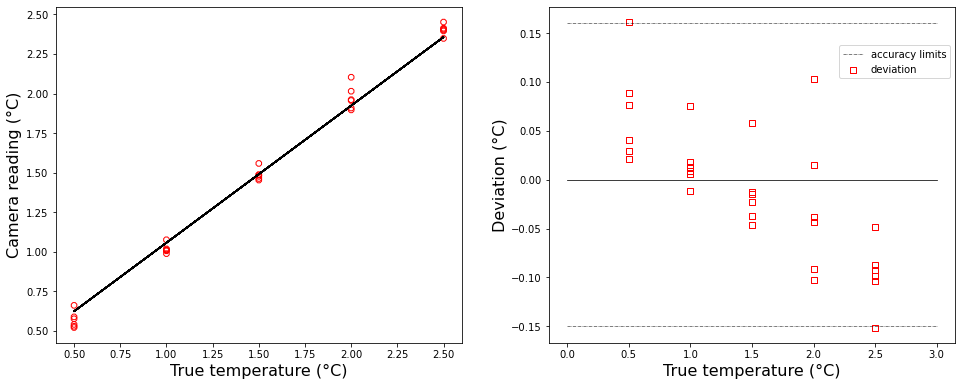

In [153]:
# plot calibration and deviation plots in one figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), facecolor="white")
fig_letter_x, fig_letter_y = (13, .85)

# plot calibration curve with best fit line
ax[0].scatter(dev_df.true_dist, dev_df.dist, marker='8', color='red', facecolors='none')
ax[0].set_ylabel('Camera reading (°C)', size=16)
ax[0].set_xlabel('True temperature (°C)', size=16)
ax[0].plot(dev_df.true_dist, dev_df.best_fit, color = "black")
ax[0].annotate(text=(f"best-fit line:\ncoeff: {round(float(lm.coef_),2)}, \nintercept: {round(float(lm.intercept_),2)}"), xy=(32,17), size=12)
ax[0].annotate(text=("a"), xy=(15,38), size=20, weight="bold")
# ax[1].text(fig_letter_x, fig_letter_y, "b", size=20, weight="bold", color="black")

# and now for the deviation plot
ax[1].scatter(dev_df["true_dist"], dev_df["deviation"], color= "red", facecolors='none', label="deviation", marker='s')
ax[1].plot([0,3], [0,0], color="black", linewidth=0.75)

ax[1].plot([0,3], [min_dev,min_dev], '-.', color="black", linewidth=0.5, label="accuracy limits")
ax[1].plot([0,3], [max_dev,max_dev], '-.', color="black", linewidth=0.5)

ax[1].set_ylabel('Deviation (°C)', size=16)
ax[1].set_xlabel('True temperature (°C)', size=16)
ax[1].legend(bbox_to_anchor=(1, .9), loc='upper right', ncol=1)
ax[1].text(fig_letter_x, fig_letter_y, "", size=20, weight="bold", color="black")




fig.tight_layout(pad=3.0)
    
plt.show()

# Discussion topics

### a. Is the accuracy of the measurements consistent across multiple working distance? Discuss the findings from the data.


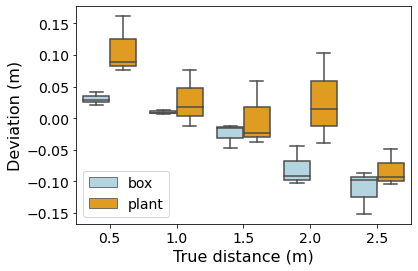

In [154]:
# establish accuracy of measurements
# for each object type, for each lighting condition, note real distance and measured distance.
sns.boxplot(x = dev_df['true_dist'], y=dev_df['deviation'], hue=dev_df['object'], palette=["lightblue", "orange"])
plt.ylabel("Deviation (m)", size=16)
plt.xlabel("True distance (m)", size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(prop={"size":14})
plt.savefig("boxplot_depth.png")


### b. Is there a difference in accuracy of the measurements with respect to object type? Discuss the findings from the data.


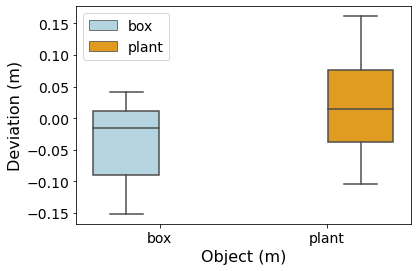

In [155]:
# compare accuracy of box to plant
sns.boxplot(x = dev_df['object'], y=dev_df['deviation'], hue=dev_df['object'], palette=["lightblue", "orange"])
plt.ylabel("Deviation (m)", size=16)
plt.xlabel("Object (m)", size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(prop={"size":14})
plt.savefig("boxplot_depth.png")


### c. Theoretically, does light conditions affect the accuracy of the sensor measurements? Based on the conducted experiment, did you observe effect of the light conditions on the data accuracy? Discuss the findings from the data.

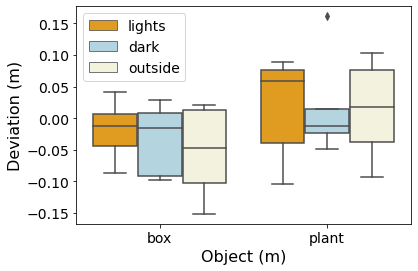

In [156]:
# light conditions, do they change accuracy? lights on, lights off, outside. 
sns.boxplot(x = dev_df['object'], y=dev_df['deviation'], hue=dev_df['condition'], palette=["orange", "lightblue", "beige" ])
plt.ylabel("Deviation (m)", size=16)
plt.xlabel("Object (m)", size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(prop={"size":14})
plt.savefig("boxplot_depth.png")